# Introduction to the Retina project – D7046E @ LTU.SE

This notebook serves as a starting point and playground for investigating what the 1D Retina project is about.
The idea is that you should familiarize yourself with both projects and later on decide which project to focus on (retina/SNN or chatbot/ANN).

In [1]:
# Enable inline plots in the notebook
%matplotlib inline

# Import library functions needed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Set default figure size
plt.rcParams['figure.figsize'] = [6,6]

# Function that is used to plot spike times
def rasterplot(ax, x, y, x_label, y_label):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x, y, marker='|')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Basic data generator

The following animation illustrates a simple motion detection task. A bright spot is moving across a one-dimensonal array of virtual receptor neurons.

![Concept illustration](https://drive.google.com/uc?export=view&id=1dc4TQ84ui5i9oVnGH9Au5sZfHKzt-2jd)

The task is to determine whether the pattern is moving and whether it is moving towards the left or right. The following code implements a basic spike data generator inspired by the animation above. For simplicity it is assumed that a bright spot is moving at constant speed back and forth, and that one spike is generated when the bright spot is passing over a receptor neuron.

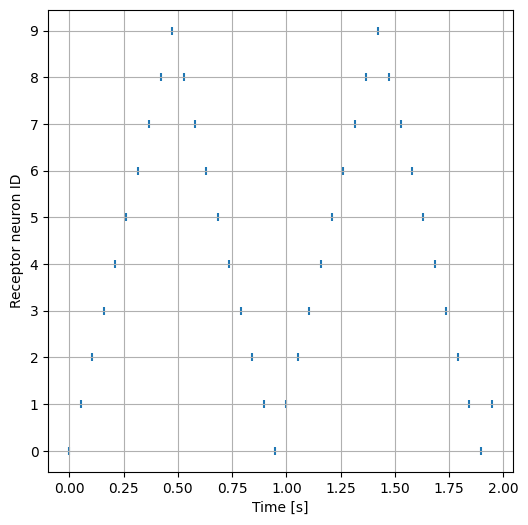

In [ ]:
####################################################################################################
# Simulation parameters
dt = 1e-4                    # Timestep
t = np.arange(0,20000)*dt    # Simulation time array t
num_receptors = 10           # Number of receptor neurons
speed = 20                   # Speed of bright spot, number of receptor neurons passed per second
####################################################################################################

plot_t = []                  # Time of spikes
plot_n = []                  # Receptor neuron id's
currtime = 0                 # Time when a spike is fired
neuronid = 0                 # Neuron that fires a spike
stepdir = 1                  # Is the bright spot moving towards the right (1) or left (-1)
timestep = 1.0/(speed-1)     # Time between spikes generated by nearby receptor neurons

# Make placeholders for spike time arrays to be used for SNN simulation
spikes = []
for i in range(num_receptors):
    spikes.append([])

# Generate and plot spikes from receptor neurons
while currtime < t[-1]:
    plot_t.append(currtime)
    plot_n.append(neuronid)
    spikes[neuronid].append(currtime)
    if neuronid == 0 and stepdir == -1:
        stepdir = 1
    elif neuronid == (num_receptors-1) and stepdir == 1:
        stepdir = -1
    neuronid += stepdir
    currtime += timestep

# Plot spikes
fig, ax = plt.subplots()
rasterplot(ax, plot_t, plot_n,'Time [s]','Receptor neuron ID')
ax.grid()

# Implement your first motion-detection SNN

There is a direction-selective network example in [Neuronify](https://ovilab.net/neuronify/), which is illustrated below. This network is designed so that the output neuron tends to fire a spike when the inputs are touched from right to left, but not when touched from left to right (with some limitations on the touching speed).

![First network implementation](https://drive.google.com/uc?export=view&id=1ZIyhUCtNebN1StlYCKEnC0qgXMZAF8d-)

Can you simulate this network using the code from SNN Exercise 1 and the input spikes provided by the data generator above? Can you modify the parameters of the simulated network so that it becomes direction selective?

If you succeed with this task then you have designed your first SNN vision system capable of basic motion detection!

**Note:** You need to complete SNN Exercise 1 to acquire the necessary background knowledge for this task.

In [ ]:
# To simulate the spikes from the receptor neurons you will need an additional neuron constructor defined as

def spike_generator(spike_times):
    # Generates spikes at time points defined by the sorted list 'spike_t'
    return {
        'type'      : 'generator',
        'spike_t'   : spike_times              # Array of spike times, separated by at least dt
}

# To incorporate this neuron type in the simulator you will need to update the spikegen(dt,t,neurons) function

def spikegen(dt, t, neurons):
    # This function implements the non-linear spike generation mechanism
    spikes = []
    for i,n in enumerate(neurons):
        if n['type'] in ['lif_cic','lif']:
            if n['u'] > n['u_thres']:
                n['u'] = n['u_reset']
                spikes.append(i)
        elif n['type'] == 'generator':
            j = np.searchsorted(n['spike_t'], t, side='right')
            if j>0 and t-n['spike_t'][j-1]<dt:
                spikes.append(i)
    return spikes

# With these modifications of the simulator code you should be able to simulate the receptor neurons using
# spike_generator neurons initialized with the spike time arrays produced by the data generator code above.

# The construction of neurons and configuration of synapses should be done in a similar way as in SNN Exercise 1.

In [ ]:
import numpy as np
import pandas as pd

# Simulation parameters
dt = 5e-2
t = np.arange(0, 20000) * dt  # Time array
num_receptors = 10
num_steps = len(t)
window_size = 2  # Number of frames per sample

# Initialize motion variables
position = 0  # Start at Receptor 0
direction = 1  # 1 = moving right, -1 = moving left
speed = 20  # Neurons per second

# Generate correct bouncing motion
positions = []
directions = []

for i in range(num_steps):
    positions.append(position)
    directions.append(direction)
    position += direction * speed * dt

    # Reverse direction at boundaries (0 and 9)
    if position >= num_receptors - 1 or position <= 0:
        direction *= -1

# Convert to NumPy arrays
positions = np.clip(np.round(positions).astype(int), 0, num_receptors - 1)
directions = np.array(directions)

# Create dataset (binary activation for receptors)
dataset = np.zeros((num_steps, num_receptors), dtype=int)
dataset[np.arange(num_steps), positions] = 1

# Create sequences of frames (samples)
X, y = [], []

for i in range(num_steps - window_size):
    sample = dataset[i : i + window_size].flatten()  # Flatten sequence
    label = directions[i + window_size - 1]  # Direction at the last frame of the sequence
    X.append(sample)
    y.append(label)

# Convert to DataFrame
df = pd.DataFrame(X, columns=[f"Frame_{i}_Receptor_{j}" for i in range(window_size) for j in range(num_receptors)])
df.insert(0, "Direction", y)  # Add direction label

# Save the dataset
df.to_csv("data_sequences.csv", index=False)

# Print checks
print(df.shape)  # (num_samples, window_size * num_receptors + 1)
#print(df.head(10))  # Check first 10 samples
#print(df[0:1])
###########################################################WITHOUT NOISE###########################################################

(19998, 21)


In [ ]:
import numpy as np
import pandas as pd

# Simulation parameters
dt = 5e-2
t = np.arange(0, 20000) * dt  # Time array
num_receptors = 10
num_steps = len(t)
window_size = 2  # Number of frames per sample
noise_level = 0.1  # Noise level for receptor activation
flip_prob = 0.02  # Probability of flipping direction labels

# Initialize motion variables
position = 0  # Start at Receptor 0
direction = 1  # 1 = moving right, -1 = moving left
speed = 20  # Neurons per second

# Generate correct bouncing motion
positions = []
directions = []

for i in range(num_steps):
    positions.append(position)
    directions.append(direction)
    position += direction * speed * dt

    # Reverse direction at boundaries (0 and 9)
    if position >= num_receptors - 1 or position <= 0:
        direction *= -1

# Convert to NumPy arrays
positions = np.clip(np.round(positions).astype(int), 0, num_receptors - 1)
directions = np.array(directions)

# Introduce random flips in direction labels
flip_mask = np.random.rand(num_steps) < flip_prob
directions[flip_mask] *= -1

# Create dataset (binary activation for receptors) with noise
dataset = np.zeros((num_steps, num_receptors))
dataset[np.arange(num_steps), positions] = 1

dataset += noise_level * np.random.randn(num_steps, num_receptors)  # Add Gaussian noise
dataset = np.clip(dataset, 0, 1)  # Keep values in valid range

# Create sequences of frames (samples)
X, y = [], []

for i in range(num_steps - window_size):
    sample = dataset[i : i + window_size].flatten()  # Flatten sequence
    label = directions[i + window_size - 1]  # Direction at the last frame of the sequence
    X.append(sample)
    y.append(label)

# Convert to DataFrame
df = pd.DataFrame(X, columns=[f"Frame_{i}_Receptor_{j}" for i in range(window_size) for j in range(num_receptors)])
df.insert(0, "Direction", y)  # Add direction label

# Save the dataset
df.to_csv("data_sequences_noisy.csv", index=False)

# Print checks
print(df.shape)  # (num_samples, window_size * num_receptors + 1)



###########################################################WITH NOISE###########################################################

(19998, 21)


# Further project work

The challenge for the **1D Retina project** is to develop a more advanced vision system for (1D) motion classification, which is not limited to one specific pattern like the bright spot in the basic data generator above.

For example, you could consider using an open image dataset for training, validation and testing. For testing, the output of a webcam could optionally be considered. The delta modulator concept introduced in SNN Exercise 1 could potentially be used to convert pixel intensities to spikes. Optionally, you can use a [DAVIS346 neuromorphic vision sensor](https://inivation.github.io/inivation-docs/Hardware%20user%20guides/User_guide_-_DAVIS346.html) to record your own dataset.

Some inspiration for the SNN network architecture and training protocol can be obtained also from SNN Exercise 2. The [Reichardt Detector](https://en.wikipedia.org/wiki/Motion_perception#The_Reichardt-Hassenstein_model) is one starting point. For further inspiration, consider for example [motion detection in insects](https://link.springer.com/content/pdf/10.1007/s00359-019-01375-9.pdf).

In addition to considering differnt types of receptor models and SNN architectures for efficient and reliable motion classification, you can consider using other SNN simulators like [Brian2](https://brian2.readthedocs.io). Optionally you can consider using accelerators like [Brian2GeNN](https://brian2genn.readthedocs.io/en/stable/introduction/).

The possibilities for exploration are endless! How does the human retina work?

In [ ]:
!pip install snntorch

#!pip install dv-processing

# Importing libraries for working with spiking neural networks (SNNs), machine learning, data visualization, and animations.
import snntorch as snn  # Library for working with spiking neural networks in PyTorch
from snntorch import spikeplot as splt  # Submodule for plotting spikes and visualizations
from snntorch import spikegen  # Submodule for generating spike data or configuring spike-related parameters

import torch  # PyTorch deep learning library
import torch.nn as nn  # Neural network module in PyTorch
from torch.utils.data import DataLoader  # DataLoader for handling datasets in PyTorch
from torchvision import datasets, transforms  # Modules for loading datasets and image transformations
import matplotlib.pyplot as plt  # Matplotlib's plotting module
import numpy as np  # NumPy for numerical computing
import itertools  # Standard library module for creating iterators

import time  # Standard library module for time-related tasks
from matplotlib.animation import FuncAnimation  # For creating animations in Matplotlib
from IPython.display import Image  # For displaying images within the IPython environment

# Importing libraries for data splitting and handling
from sklearn.model_selection import train_test_split  # Function for splitting datasets
import pandas as pd  # Pandas for data manipulation and analysis
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from torchvision import transforms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 5.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import snntorch as snn

# Define SNN Model
class SpikingNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(20, 50)  # Input layer (20) → Hidden layer (50)
        self.lif1 = snn.Leaky(beta=0.9)  # Leaky Integrate-and-Fire neuron

        self.fc2 = nn.Linear(50, 10)  # Hidden layer (50) → Hidden layer (10)
        self.lif2 = snn.Leaky(beta=0.9)

        self.fc3 = nn.Linear(10, 1)  # Hidden layer (10) → Output layer (1)
        self.lif3 = snn.Leaky(beta=0.9)

    def forward(self, x):
        spk1, mem1 = self.lif1(self.fc1(x))  # First layer
        spk2, mem2 = self.lif2(self.fc2(mem1))  # Second layer
        spk3, mem3 = self.lif3(self.fc3(mem2))  # Output layer

        return mem3  # Return membrane potential (continuous value)

In [ ]:
#Splitting the dataset
# Load dataset
df = pd.read_csv("data_sequences_noisy.csv")

# Extract features (X) and labels (y)
X = df.iloc[:, 1:].values.astype(np.float32)  # All columns except 'Direction'
y = df.iloc[:, 0].values.astype(np.float32)   # 'Direction' column (labels)

# Convert labels to {0,1} for binary classification
y[y == -1] = 0  # Convert -1 to 0

# Convert to PyTorch tensors
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y).unsqueeze(1)  # Add extra dimension for single neuron output

# Split dataset (60% train, 20% val, 20% test)
num_samples = len(X_tensor)
train_size = int(0.6 * num_samples)
val_size = int(0.2 * num_samples)
test_size = num_samples - train_size - val_size  # Ensure total adds up

train_data, val_data, test_data = random_split(
    TensorDataset(X_tensor, y_tensor),
    [train_size, val_size, test_size]
)

# DataLoader setup
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# DataLoader for test set
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

NameError: name 'random_split' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split




# Define SNN Model
class SpikingNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 50)
        self.lif1 = snn.Leaky(beta=0.9, reset_mechanism="zero")
        self.fc2 = nn.Linear(50, 10)
        self.lif2 = snn.Leaky(beta=0.9, reset_mechanism="zero")
        self.fc3 = nn.Linear(10, 1)
        self.lif3 = snn.Leaky(beta=0.9, reset_mechanism="zero")

    def forward(self, x):
        mem1 = self.lif1.init_leaky()  # Reset membrane state
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk1, mem1 = self.lif1(self.fc1(x), mem1)
        spk2, mem2 = self.lif2(self.fc2(mem1), mem2)
        spk3, mem3 = self.lif3(self.fc3(mem2), mem3)

        return mem3  # Membrane potential as output

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikingNN().to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with model saving
num_epochs = 20
best_val_loss = float("inf")  # Track best validation loss

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Accuracy calculation
            predictions = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary 0/1
            correct += (predictions == targets).sum().item()
            total += targets.size(0)

    val_acc = correct / total
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # **Save model if it's the best one so far**
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_snn_model.pth")
        print("New best model - saved")

print("Training complete. Best model saved as 'best_snn_model.pth'")

Epoch 1/20 - Train Loss: 0.5594, Val Loss: 0.3834, Val Acc: 0.8555
New best model - saved
Epoch 2/20 - Train Loss: 0.3018, Val Loss: 0.2371, Val Acc: 0.9167
New best model - saved
Epoch 3/20 - Train Loss: 0.2536, Val Loss: 0.2283, Val Acc: 0.9177
New best model - saved
Epoch 4/20 - Train Loss: 0.2496, Val Loss: 0.2292, Val Acc: 0.9180
Epoch 5/20 - Train Loss: 0.2497, Val Loss: 0.2296, Val Acc: 0.9170
Epoch 6/20 - Train Loss: 0.2494, Val Loss: 0.2281, Val Acc: 0.9172
New best model - saved
Epoch 7/20 - Train Loss: 0.2497, Val Loss: 0.2288, Val Acc: 0.9147
Epoch 8/20 - Train Loss: 0.2486, Val Loss: 0.2280, Val Acc: 0.9140
New best model - saved
Epoch 9/20 - Train Loss: 0.2484, Val Loss: 0.2279, Val Acc: 0.9147
New best model - saved
Epoch 10/20 - Train Loss: 0.2488, Val Loss: 0.2286, Val Acc: 0.9150
Epoch 11/20 - Train Loss: 0.2497, Val Loss: 0.2304, Val Acc: 0.9140
Epoch 12/20 - Train Loss: 0.2490, Val Loss: 0.2281, Val Acc: 0.9152
Epoch 13/20 - Train Loss: 0.2485, Val Loss: 0.2277, Val

In [ ]:
import torch
import torch.nn as nn
import snntorch as snn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split






# Define the same SNN model as before
class SpikingNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 50)
        self.lif1 = snn.Leaky(beta=0.9, reset_mechanism="zero")
        self.fc2 = nn.Linear(50, 10)
        self.lif2 = snn.Leaky(beta=0.9, reset_mechanism="zero")
        self.fc3 = nn.Linear(10, 1)
        self.lif3 = snn.Leaky(beta=0.9, reset_mechanism="zero")

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk1, mem1 = self.lif1(self.fc1(x), mem1)
        spk2, mem2 = self.lif2(self.fc2(mem1), mem2)
        spk3, mem3 = self.lif3(self.fc3(mem2), mem3)

        return mem3  # Output membrane potential

# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikingNN().to(device)
model.load_state_dict(torch.load("best_snn_model.pth"))
model.eval()  # Set to evaluation mode

# Define loss function
criterion = nn.BCEWithLogitsLoss()

# Evaluate on test set
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        # Compute accuracy
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predictions == targets).sum().item()
        total += targets.size(0)

# Compute final test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_acc = correct / total

print(f"✅ Test Loss: {avg_test_loss:.4f}, Test Accuracy: {100*test_acc:.4f}%")

<ipython-input-30-5076b9f8f06e>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_snn_model.pth"))


✅ Test Loss: 0.2347, Test Accuracy: 91.8020%
